In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os import path
import pandas as pd
from urllib.request import urlretrieve
import zipfile
import sys
import seaborn as sns
import random
from scipy.optimize import minimize
from sklearn import linear_model, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model.base import LinearModel
from sklearn.base import RegressorMixin
from sklearn.model_selection import GridSearchCV


%matplotlib inline

# Exercice 1

#### 1) Sur un même graphique, dont l'abscisse minimal et maximal seraient -5 et 5, tracer ρα pour α = 5, 2, 5. Décrire l'effet de alpha sur l'estimation

In [2]:
#x ndarray
def ro (alpha,x) :
    """Fonction ro (x,alpha)"""
    #creation d'un nouveau vecteur de même taille dans lequel je stocke mes opérations sur x aux indices renvoyés par 
    #le masque booleen
    y = np.zeros(x.shape)
    if alpha == 0:
        y = np.abs(x)
    else :
        y[np.abs(x) > alpha] = (alpha * np.abs(x[np.abs(x)>alpha])) - (alpha**2)/2
        y[np.abs(x) <= alpha] = (x[np.abs(x) <= alpha]**2)/2
    return y

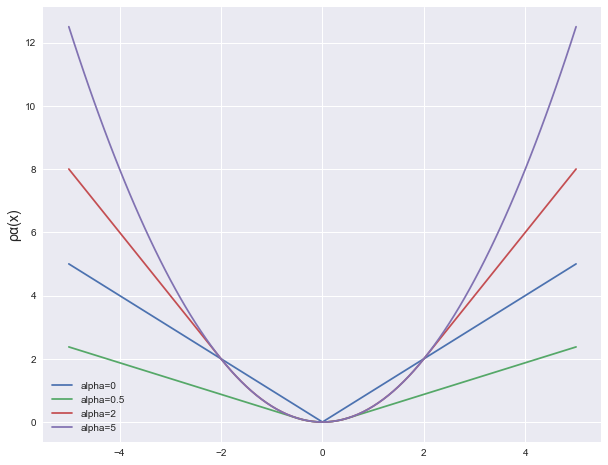

In [3]:
#Plot
x = np.linspace(start=-5, stop=5, num=101)

fig,ax = plt.subplots(figsize=(10,8))
ax.plot(np.linspace(start=-5, stop=5, num=101),ro(0,x))
ax.plot(np.linspace(start=-5, stop=5, num=101),ro(0.5,x))
ax.plot(np.linspace(start=-5, stop=5, num=101),ro(2,x))
ax.plot(np.linspace(start=-5, stop=5, num=101),ro(5,x))
ax.set_ylabel("ρα(x)", fontsize=14)
ax.legend(["alpha=0","alpha=0.5","alpha=2","alpha=5"])

On observe que plus alpha est grand plus mon modèle s'approche des moindre carrés, la représentation des résidus est quadratique.
En revanche avec alpha=0 on a une représentation de mes résidus qui suit la fonction valeur absolue, on se retrouve donc dans le cas du LAD.
En conclusion plus alpha est grand plus mon modèle sera sensible aux points extrêmes, il aura tendance à avoir un faible biais et une variance importante. Plus mon alpha est petit moins il se sera sensible aux points extremes, il aura tendance à avoir un biais important et une variance faible.

####  2) Générer n =100 vecteurs aléatoires (yi , xi) selon le modèle précédent avec d=2, θ =(1,1), θ0=1 et εi gaussien de moyenne 0 et variance 1

In [29]:
# Je génère matrice x et le bruit ε gaussien
X = np.random.uniform(low=0,high=1,size=(100,2))
ε_gauss = np.random.normal(loc=0,scale=1,size=(100,1))

#theta*
theta_etoile = np.array([1,1]).reshape(2,1)
theta_etoile_0 = 1

#Je calcul mon y
y = theta_etoile_0 + ε_gauss + np.dot(X,theta_etoile)

####  3) Pour α=2, calculer θα. On pourra importer minimize de scipy.optimize

In [30]:
#Reformatage du code
def compute_minimize(X,y,alpha,theta):
    """Compute la fonction minimize et retourne le theta optimal"""
    def f(theta):
        theta_array = np.array(theta[1:])
        return np.sum(ro(alpha,(y - theta[0] - np.dot(X,theta_array.reshape(-1,1)))))
   
    res = minimize(f,theta, method='nelder-mead',options={'xtol': 1e-5})
    if res.success:
        return res.x 

In [31]:
#resolution
theta_estime = compute_minimize(X,y,2,[0,0,0])
print(theta_estime)

[ 1.18370242  1.02648354  0.83441973]


Les paramètres estimés retournés doivent être proches de (1,1,1) vrai paramètre de mon modèle. Les résultats semblent cohérents

#### 4) En utilisant le bootstrap des résidus, calculer un estimateur bootstrap θα pour α = 2.

In [32]:
#Calcul des residus
y_predict = np.dot(X,theta_estime[1:]) + theta_estime[0]
residus = y.reshape(-1,) - y_predict

In [33]:
#Reformatage
def compute_theta_boot (X,y,alpha,theta_estime,residus) :
    #residus 1D array
    residus_random = np.random.choice(residus,size=residus.size)
    y_boot = np.dot(X,theta_estime[1:].reshape(-1,1)) + theta_estime[0] + residus_random.reshape(-1,1)
    theta_init = [0 for elt in theta_estime]
    theta_boot = compute_minimize(X,y_boot,alpha,theta_init)
    return theta_boot
    

In [34]:
theta_boot = compute_theta_boot(X,y,2,theta_estime,residus)
print(theta_boot)

[ 1.35061037  0.79288348  0.64494228]


#### 5) Toujours pour α =2, à partir de B =200 réplications d'estimateurs bootstrap θi,α (issues de la question précédente), calculer un estimateur de la matrice de variance Vboot (la matrice de covariance empirique associée à l'échantillon (d'estimateurs) et un estimateur du biais Bboot

Ici je ferais deux méthodes, d'abord sans encapsuler minimize dans une fonction puis en l'encapsulant. 

In [35]:
def f(theta):
    theta_array = np.array(theta[1:])
    return np.sum(ro(alpha,(y_res - theta[0] - np.dot(X,theta_array.reshape(-1,1)))))

In [36]:
theta_init = [0,0,0]
B = 200
theta_boot_matrix = np.zeros((B,3))
alpha = 2
for i in range(0,B):
    #tirage de mes residus & compute y
    residus_random = np.random.choice(residus,size=residus.size)
    y_boot = np.dot(X,theta_estime[1:].reshape(-1,1)) + theta_estime[0] + residus_random.reshape(-1,1)
    y_res = y_boot
    
    #resolution
    res = minimize(f,theta_init, method='nelder-mead',options={'xtol': 1e-5})
    if res.success:
        theta_boot_matrix[i] = res.x
        
#affichage
df = pd.DataFrame(theta_boot_matrix,columns=["θ0","θ1","θ2"])
print("Visualisation des 10 premiers rows de ma matrice theta bootstrap")
df[:10]
    

Visualisation des 10 premiers rows de ma matrice theta bootstrap


,θ0,θ1,θ2
0,1.051583,0.966399,1.175085
1,0.644477,1.690867,1.231619
2,0.956454,1.196476,0.771725
3,1.103892,1.440461,0.531759
4,1.355354,0.859082,0.776690
5,1.239517,1.143197,0.629179
6,1.732917,0.356167,0.592056
7,1.274036,0.669392,1.142081
8,1.221922,0.978798,0.916446
9,1.386824,0.764590,0.905607


In [37]:
#Encapsule minimize dans compute_theta_boot
B = 200
theta_boot_matrix2 = np.zeros((B,3))
for i in range(0,B):
    theta_boot_matrix2[i] = compute_theta_boot(X,y,2,theta_estime,residus)

df = pd.DataFrame(theta_boot_matrix2,columns=["θ0","θ1","θ2"])
print("Visualisation des 10 premiers rows de ma matrice theta bootstrap")
df[:10]

Visualisation des 10 premiers rows de ma matrice theta bootstrap


,θ0,θ1,θ2
0,1.606850,0.535128,0.666861
1,1.596924,0.398612,0.514832
2,1.013142,1.233297,0.784906
3,1.739709,0.431822,0.335441
4,0.941229,1.056399,0.999329
5,1.763633,0.364939,0.464461
6,1.148628,1.231101,0.980312
7,1.151730,0.752638,1.164564
8,1.431965,0.716925,0.679424
9,1.528367,0.664184,0.686279


In [38]:
#Calcul du biais
n,p = theta_boot_matrix.shape
B_boot = np.sum(theta_boot_matrix - theta_estime,axis=0)/n 
print("Biais bootstrap = ", B_boot)
print("---------------------------")

#Calcul matrice de variance
V_boot = np.cov(np.transpose(theta_boot_matrix))
print("Matrice de variance :",V_boot)

Biais bootstrap =  [-0.01600601  0.01551574  0.00783785]
---------------------------
Matrice de variance : [[ 0.05512927 -0.04803084 -0.05385661]
 [-0.04803084  0.08804185  0.01581234]
 [-0.05385661  0.01581234  0.09512922]]


In [39]:
# Calcul eqm
eqm = np.sum(np.sum(((theta_boot_matrix - theta_estime)**2),axis=1)) / B
print("erreur quadratique moyenne : ",eqm)

erreur quadratique moyenne :  0.237667201117


In [40]:
#Verification eqm
theta_boot_mean = np.mean(theta_boot_matrix,axis=0)
terme1 = np.sum((theta_estime - theta_boot_mean)**2)
terme2 = np.sum(np.sum(((theta_boot_matrix - theta_boot_mean)**2),axis=1)) / B
print("Verification de l'égalité : ",terme1 + terme2)

Verification de l'égalité :  0.237667201117


In [19]:
#APARTE DECOUVERTE D'UN BUG
B = 200
theta_boot_matrix2 = np.zeros((B,3))
for i in range(0,B):
    theta_boot_matrix2[i] = compute_theta_boot(X,y,0,theta_estime,residus)

df = pd.DataFrame(theta_boot_matrix2,columns=["theta0","theta1","theta2"])
df.isnull().sum()

theta0    15
theta1    15
theta2    15
dtype: int64

J'ai un bug qui est apparu dans l'utilisation de ma fonction compute_theta_boot(). Pour α = 0 j'ai souvent des nan que je n'ai pas réussi à expliquer. N'ayant pas trouvé l'origine de ce bug, j'ai choisi de ne pas utiliser cette fonction et donc de ne pas encapsuler minimize dans une fonction.

#### 6) Sur une grille de 20 points équidistants entre 0 et 10, tracer EQMboot(α) pour α variant sur cette grille

In [41]:
#creation de magrille alpha
grille_alpha = np.arange(0,10,0.5)
eqm_array = np.zeros(grille_alpha.size)

In [42]:
def compute_theta_residu(X,y,alpha,dim_theta):
    """Retourne le theta estimé et les résidus pour un alpha donnée. Etape en amont du bootstrap"""
    theta_init = [0 for i in range(0,dim_theta)]
    theta_estime = compute_minimize(X,y,alpha,theta_init)
    y_predict = np.dot(X,theta_estime[1:]) + theta_estime[0]
    residus = y.reshape(-1,) - y_predict
    return theta_estime,residus

In [43]:
def compute_y_bootstrap(X,theta_estime,residus):
    """Retourne le y_bootstrap à partir duquel on calculera l'estimateur bootstrap via minimize"""
    residus_random = np.random.choice(residus,size=residus.size)
    y_boot = np.dot(X,theta_estime[1:].reshape(-1,1)) + theta_estime[0] + residus_random.reshape(-1,1)
    return y_boot

In [44]:
#Bootstrap des residus pour différents alpha
for index_alpha,alpha in enumerate(grille_alpha):
    #j'initialise ma matrice θ_boot
    theta_boot_matrix = np.zeros((B,3),dtype=float)

    #calcul de mon theta_estime et résidus pour chaque alpha
    theta_estime,residus = compute_theta_residu(X,y,alpha,3)

    for i in range(0,B):
        #tirage de mes residus & compute y
        y_res = compute_y_bootstrap(X,theta_estime,residus)
        
        #resolution
        res = minimize(f,theta_init, method='nelder-mead',options={'xtol': 1e-5})
        if res.success:
            theta_boot_matrix[i] = res.x
            
    #Compute eqm
    eqm_array[index_alpha] = np.sum(np.sum(((theta_boot_matrix - np.transpose(theta_estime))**2),axis=1)) / B


In [45]:
#α minimisant la mse
index = np.argmin(eqm_array)
print(eqm_array)
print("Le α minimisant l'eqm est : ",grille_alpha[index])

[ 0.76880391  0.32401152  0.24573912  0.27484022  0.23692073  0.23700886
  0.21363245  0.24322829  0.24143078  0.22480021  0.25226983  0.2517221
  0.23365075  0.25307557  0.22867438  0.25309016  0.24058319  0.23164276
  0.22054143  0.25281876]
Le α minimisant l'eqm est :  3.0


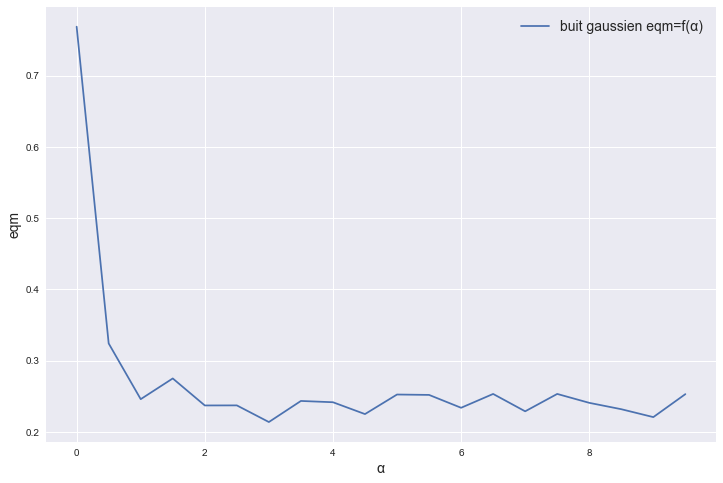

In [47]:
#Plot de l'eqm en fonction de α
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(grille_alpha,eqm_array)
ax.set_ylabel("eqm",fontsize=14)
ax.set_xlabel("α",fontsize=14)
ax.legend(["buit gaussien eqm=f(α)"],fontsize=14)

In [48]:
print("moyenne des residus : ",residus.mean())
print( "variance des residus : ",residus.var())

moyenne des residus :  1.24134464656e-06
variance des residus :  0.761631033034


Rappel : Faire varier α va modifier la fonction à minimiser en la faisant varier d'une fonction proche de la valeur absolue (proche de LAD), à une fonction proche d'une distribution quadratique (proche de Least Square). 

On constate qu'avec le bruit ε suivant une loi gaussienne (centrée,reduites) et donc avec nos résidus suivant cette même loi, l'eqm du bootstrap semble converger pour α>2.

#### 7) On change maintenant la distribution des erreurs. On prend une loi standard de Cauchy (générée sous numpy par numpy.random.standard_cauchy(n)). Tracer le même graphique qu'à la question précédente. Conclure.

In [54]:
#Compute ε with Cauchy
ε_cauchy = np.random.standard_cauchy((100,1))

#generation de mes y observés sur la base cette fois d'un bruit suivant une loi de Cauchy
y_cauchy = theta_etoile_0 + ε_cauchy + np.dot(X,theta_etoile)

In [55]:
#Test pour alpha =2 
theta_estime_cauchy,residus_cauchy = compute_theta_residu(X,y_cauchy,2,3)
print("Moyenne des residus pour alpha=2 :",residus_cauchy.mean())
print("Variance des residus pour alpha=2 : ",residus_cauchy.var())

Moyenne des residus pour alpha=2 : 0.563829503563
Variance des residus pour alpha=2 :  31.0352162797


Je peux déjà remarquer que lorsque le bruit n'est plus gaussien de moyenne nulle, mes résidus de ne sont plus centrés.

In [56]:
eqm_array_cauchy = np.zeros(grille_alpha.size)

for index_alpha,alpha in enumerate(grille_alpha):
    #j'initialise ma matrice θ_boot
    theta_boot_matrix = np.zeros((B,3),dtype=float)
    
    #calcul de mon theta_estime et résidus pour chaque alpha
    theta_estime_cauchy,residus_cauchy = compute_theta_residu(X,y_cauchy,alpha,3)
    
    #compute theta bootstraps matrix
    for i in range(0,B):
        #tirage de mes residus & compute y
        y_res = y_res = compute_y_bootstrap(X,theta_estime_cauchy,residus_cauchy)
        
        #resolution
        res = minimize(f,theta_init, method='nelder-mead',options={'xtol': 1e-5})
        if res.success:
            theta_boot_matrix[i] = res.x
    #Compute eqm
    eqm_array_cauchy[index_alpha] = np.sum(np.sum(((theta_boot_matrix - np.transpose(theta_estime_cauchy))**2),axis=1)) / B


In [57]:
print(eqm_array_cauchy)
print("alpha min : ",grille_alpha[np.argmin(eqm_array_cauchy)])

[ 1.05426884  0.76929885  0.88344662  0.93329673  0.99754223  1.25790421
  1.36489503  1.77866889  1.91656873  2.30658067  2.39890681  2.41078313
  3.00521291  2.97518792  2.70825746  3.36104576  3.12658313  2.9532683
  3.88571972  3.35124737]
alpha min :  0.5


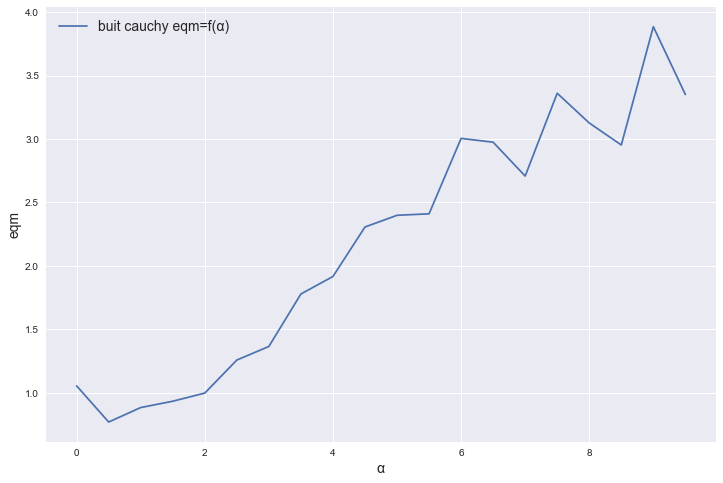

In [58]:
#Plot de l'eqm en fonction de α
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(grille_alpha,eqm_array_cauchy)
ax.set_ylabel("eqm",fontsize=14)
ax.set_xlabel("α",fontsize=14)
ax.legend(["buit cauchy eqm=f(α)"],fontsize=14)

On remarque que l'eqm semble diverger.

Plus mon α est grand, plus mes estimateurs sont sensibles aux outliers et auront tendance à "overfitter" mon jeu de données. (cf question 1 plot de ro en fonction de alpha)

Du fait de la grande variance de mes résidus, mes y_bootstraps calculés sur la base d'un tirage aléatoire des residus peuvent être relativement différents de mon y d'origine : (comportés plusieurs fois certains outiliers, pas d'autres etc...)

En outre mes y_bootstrap auront une variance très importante au vu de la variance des résidus.
Or plus mon α est grand plus mes θ bootstraps auront une variance importante car ils auront tendance à "overfitter" le dataset (X,y_bootstrap) auquel chacun sera associé. Sachant que chaque y_bootstrap a une variance forte et des outliers potentiellements différents du y d'origine, je vais de plus en plus m'eloigner de mes paramètres theta estimés avec(alpha, X, y) en overfittant chaque dataset bootstrap.

A cause du bruit de cauchy , la combinaison du décalage de y_bootstrap vis à vis a de y (mean des residus différent de 0), et surtout de l'augmentation de la variance de mes estimateurs bootstap avec alpha (tendance à overfitter y_bootstrap,X) résultent sur une augmentation globale de l'eqm avec α.


#### 8) Charger la base "diabetese" de sklearn. Appliquer la méthode précédente au choix du coefficient α pour la régression de y sur la quatrième variable de la base. On veillera à bien choisir le domaine des α pour optimiser le EQMbootα.

In [59]:
#Telechargons la table
X_features,y_diabete = datasets.load_diabetes(return_X_y=True)

#Effectuons la regression de y sur la 4e feautre en minimisant selon fα
X = X_features[:,3].reshape(-1,1)
y_diabete = y_diabete.reshape(-1,1)

In [60]:
print("4e Feature du DataSet ",X[:10])
print("\n Target ",y[:10])

4e Feature du DataSet  [[ 0.02187235]
 [-0.02632783]
 [-0.00567061]
 [-0.03665645]
 [ 0.02187235]
 [-0.01944209]
 [-0.01599922]
 [ 0.06662967]
 [-0.04009932]
 [-0.03321358]]

 Target  [[ 2.07343724]
 [ 1.14029917]
 [ 1.1264629 ]
 [ 0.88320976]
 [ 0.78763272]
 [ 2.18853727]
 [ 0.66730353]
 [ 1.41016891]
 [ 1.26319348]
 [ 2.58609723]]


In [81]:
#essayons dans un premier temps avec une grille large
grille_alpha_diabete = np.arange(0,300,30)
eqm_array_diabete = np.zeros(grille_alpha_diabete.size)
theta_init_diabete = [0,0]


for index_alpha,alpha in enumerate(grille_alpha_diabete):
    #j'initialise ma matrice θ_boot
    theta_boot_matrix = np.zeros((B,2))
 
    theta_estime_diabete,residus_diabete = compute_theta_residu(X,y_diabete,alpha,2)
    print("theta alpha=",alpha," ",theta_estime_diabete)

    for i in range(0,B):
        #tirage de mes residus & compute y
        y_res = compute_y_bootstrap(X,theta_estime_diabete,residus_diabete)
        #resolution
        res = minimize(f,theta_init_diabete, method='nelder-mead',options={'xtol': 1e-5})
        if res.success:
                theta_boot_matrix[i] = res.x
    print("estimateur bootstrap 3 premier rang",theta_boot_matrix[:3])
    print("------------------------------------")
    #compute eqm
    eqm_array_diabete[index_alpha] = np.sum(np.sum(((theta_boot_matrix - np.transpose(theta_estime_diabete))**2),axis=1))/B
    

theta alpha= 0   [ 147.04099846  888.96921205]
estimateur bootstrap 3 premier rang [[ 151.78660562  825.78576277]
 [ 145.68328347  909.03707989]
 [ 150.13055271  980.85869345]]
------------------------------------
theta alpha= 30   [ 147.47371536  863.98363923]
estimateur bootstrap 3 premier rang [[ 158.7169567   848.76693703]
 [ 139.29594403  954.34777023]
 [ 140.54614856  664.62185375]]
------------------------------------
theta alpha= 60   [ 149.01978517  836.36386718]
estimateur bootstrap 3 premier rang [[ 148.38956101  781.39388195]
 [ 151.9897068   980.54612433]
 [ 148.52766397  775.89156404]]
------------------------------------
theta alpha= 90   [ 150.07814077  781.36045583]
estimateur bootstrap 3 premier rang [[ 152.33542638  854.96476948]
 [ 150.29432214  844.75216243]
 [ 156.51239515  796.28296685]]
------------------------------------
theta alpha= 120   [ 150.96549619  741.79151562]
estimateur bootstrap 3 premier rang [[ 146.62908923  690.66911556]
 [ 150.70459552  759.4394

In [82]:
print(eqm_array_diabete)
print("alpha min : ",grille_alpha_diabete[np.argmin(eqm_array_diabete)])

[ 51669.11753707   7470.34339388   6492.19470395   5526.25949423
   4426.68755437   5487.18521146   4762.48218304   4800.01004428
   6614.76195027   5362.71984379]
alpha min :  120


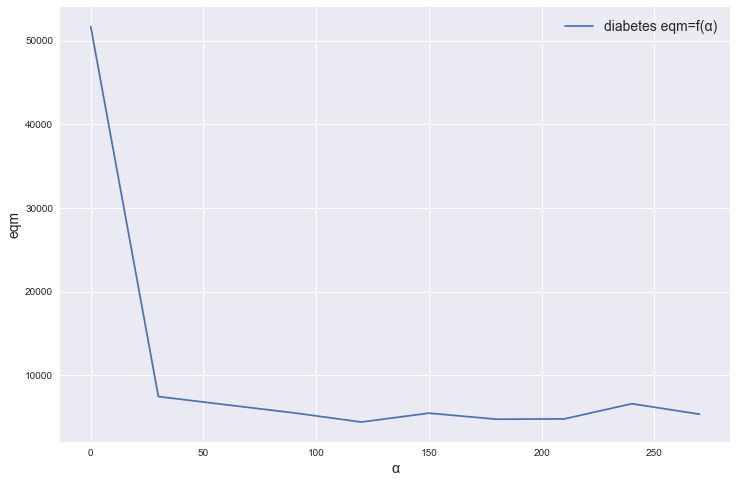

In [83]:
#Plot de l'eqm en fonction de α
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(grille_alpha_diabete,eqm_array_diabete)
ax.set_ylabel("eqm",fontsize=14)
ax.set_xlabel("α",fontsize=14)
ax.legend(["diabetes eqm=f(α)"],fontsize=14)

D'après ce premier passage grossier le α minimisant l'eqm semble être entre 100 et 140, réalisons un second passage dans cette zonne

In [85]:
#essayons dans un premier temps avec une grille large
grille_alpha_diabete = np.arange(100,140,10)
eqm_array_diabete = np.zeros(grille_alpha_diabete.size)
#caluclons la mse pour chaque α
for index_alpha,alpha in enumerate(grille_alpha_diabete):
    #j'initialise ma matrice θ_boot
    theta_boot_matrix = np.zeros((B,2))
 
    theta_estime_diabete,residus_diabete = compute_theta_residu(X,y_diabete,alpha,2)
    for i in range(0,B):
        #cf APARTE Q.5
        #tirage de mes residus & compute y
        y_res = compute_y_bootstrap(X,theta_estime_diabete,residus_diabete)
        #resolution
        res = minimize(f,theta_init_diabete, method='nelder-mead',options={'xtol': 1e-5})
        if res.success:
            theta_boot_matrix[i] = res.x
    eqm_array_diabete[index_alpha] = np.sum(np.sum(((theta_boot_matrix - np.transpose(theta_estime_diabete))**2),axis=1))/B



In [86]:
print(eqm_array_diabete)
print("alpha min : ",grille_alpha_diabete[np.argmin(eqm_array_diabete)])

[ 7897.442565    4336.08253118  4240.29968935  4364.07218664]
alpha min :  120


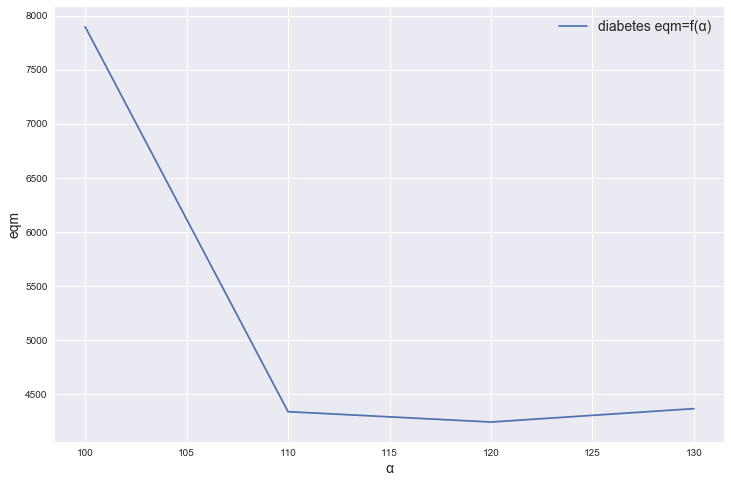

In [87]:
#Plot de l'eqm en fonction de α
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(grille_alpha_diabete,eqm_array_diabete)
ax.set_ylabel("eqm",fontsize=14)
ax.set_xlabel("α",fontsize=14)
ax.legend(["diabetes eqm=f(α)"],fontsize=14)

# Exercice 2

#### 9) Standardiser les données (centrer et réduire pour obtenir une matrice X qui a des variances unitaire par colonne).

In [88]:
import statsmodels.datasets as sd
data = sd.get_rdataset('airquality').data

In [89]:
print(pd.isnull(data).sum())
#drop brutal des na
data.dropna(how='any',inplace=True)
print("\n suppression des valeurs nulles")
print("-------------------- \n")
print(pd.isnull(data).sum())

Ozone      37
Solar.R     7
Wind        0
Temp        0
Month       0
Day         0
dtype: int64

 suppression des valeurs nulles
-------------------- 

Ozone      0
Solar.R    0
Wind       0
Temp       0
Month      0
Day        0
dtype: int64


In [90]:
#definition de mon X et y
X_air = data.iloc[:,1:]
y_air = data.iloc[:,0]

In [91]:
#centre et reduit X
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_air)
X_air_normalized = pd.DataFrame(scaler.transform(X_air), columns=X_air.columns)

print("Verification")
X_air_normalized.describe()

Verification


,Solar.R,Wind,Temp,Month,Day
count,1.110000e+02,1.110000e+02,1.110000e+02,1.110000e+02,1.110000e+02
mean,-1.265254e-16,2.785560e-16,-4.240852e-16,-1.120225e-16,1.240249e-16
std,1.004535e+00,1.004535e+00,1.004535e+00,1.004535e+00,1.004535e+00
min,-1.959448e+00,-2.157084e+00,-2.191727e+00,-1.510938e+00,-1.724290e+00
25%,-7.857746e-01,-7.170778e-01,-7.160148e-01,-8.291733e-01,-8.013427e-01
50%,2.446331e-01,-6.766325e-02,1.272493e-01,-1.474086e-01,6.236130e-03
75%,7.791227e-01,4.405743e-01,7.069934e-01,1.216121e+00,7.561308e-01
max,1.644224e+00,3.038233e+00,2.024594e+00,1.216121e+00,1.736762e+00


#### 10) Écrivez une fonction stpforward

In [92]:
def stpforward(X, y, M):
    """Orthogonal Matching Pursuit model (OMP).
    X: Array-like, shape (n_samples, n_features).
    Training data.
    y: Array-like, shape (n_samples, ).
    Target values.
    M: Integer, in [1,n_features]"""
    
    selected_variables = []
    residual = y
    p = X.shape[1] #features number
    coef_selected = np.zeros(p) #stocke mes theta int
    
    for i in range(1, M + 1):
        tab_alphaj = np.zeros(p) 
        for j in range(0, p):
            if(j not in selected_variables):
                Xj = X[:, j] #je recupere ma colonne feature j
                valeur_alphaj = np.abs(np.dot(np.transpose(Xj),residual)) #je fais la valeurs abs du prod scalaire, verif dim
                tab_alphaj[j] = valeur_alphaj # je stocke dans mon alphaj
       
        jmax = np.argmax(tab_alphaj) #je recup l'argument max
        selected_variables.append(jmax) #je mets à jour mes selected variables
        X_selected = X[:, selected_variables]
        
        skl_linmod = linear_model.LinearRegression()
        skl_linmod.fit(X_selected,y)
        
        coef_selected[selected_variables] = skl_linmod.coef_
        #update residual
        residual = y - np.dot(X_selected,coef_selected[selected_variables])
    
    return coef_selected, selected_variables


In [93]:
#Test rapide
coeff,selected = stpforward(X_air_normalized.values,y_air.values,1)
print(selected)
print(coeff)

[2]
[  0.           0.          23.13969957   0.           0.        ]


#### 11) Créer une classe MYOMP qui implémente stpforward

In [94]:
class MYOMP(LinearModel, RegressorMixin):
    """Orthogonal Matching Pursuit model (OMP).
    Parameters
    ----------
    n_nonzero_coefs : int, optional
    Desired number of non-zero entries in the solution. If None (by
    default) this value is set to 10% of n_features.
    """

    def __init__(self, n_nonzero_coefs=None, fit_intercept=False,normalize=False, precompute='auto'):
        self.fit_intercept = False
        self.normalize = normalize
        self.precompute = precompute
        self.n_nonzero_coefs = n_nonzero_coefs #nombre de coeff non-nuls voulues
        self.selected = [] #ajout d'un attribut stockant les features selectionnées

    def fit(self, X, y):
        """Fit the model using X, y as training data.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features) Training data.
        y : array-like, shape (n_samples,) or (n_samples, n_targets) Target values.
        Returns
        -------
        self : object
        returns an instance of self.
        """
        #attribut coeff hérité de la classe mère LinearModel
        self.coef_ = np.zeros([X.shape[1], ])
        #intercept definit nul afin de pouvoir utiliser l'estimateur myop dans gridsearchCV
        self.intercept_ = 0
        self.coef_, self.selected = stpforward(X,y,self.n_nonzero_coefs)
        
     
        return self

#### 12)  Appliquer MYOMP au jeu de données, pour M 1, 2, 3, 4, 5.

In [95]:
#Test de ma classe pour M=1,2,3,4,5
print("Rappel des features de X",X_air.columns.values)

myomp = MYOMP(n_nonzero_coefs=1)
myomp.fit(X_air_normalized.values,y_air.values)
print("\n Pour 1 feature selectionnée :",myomp.coef_)

myomp = MYOMP(n_nonzero_coefs=2)
myomp.fit(X_air_normalized.values,y_air.values)
print("\n Pour 2 features selectionnées :",myomp.coef_)

myomp = MYOMP(n_nonzero_coefs=3)
myomp.fit(X_air_normalized.values,y_air.values)
print("\n Pour 3 features selectionnées :",myomp.coef_)

myomp = MYOMP(n_nonzero_coefs=4)
myomp.fit(X_air_normalized.values,y_air.values)
print("\n Pour 4 features selectionnées :",myomp.coef_)

myomp = MYOMP(n_nonzero_coefs=5)
myomp.fit(X_air_normalized.values,y_air.values)
print("\n Pour 5 features selectionnées :",myomp.coef_)

Rappel des features de X ['Solar.R' 'Wind' 'Temp' 'Month' 'Day']

 Pour 1 feature selectionnée : [  0.           0.          23.13969957   0.           0.        ]

 Pour 2 features selectionnées : [  0.         -11.66917173  17.33790739   0.           0.        ]

 Pour 3 features selectionnées : [  5.42816683 -11.80641781  15.67331326   0.           0.        ]

 Pour 4 features selectionnées : [  4.50045463 -11.74591966  17.7488752   -4.38806519   0.        ]

 Pour 5 features selectionnées : [  4.56193076 -11.75277084  17.98521995  -4.45895297   2.37393859]


Le test semble concluant

#### 13) Comparer votre sortie avec celle de OrthogonalMatchingPursuit de sklearn.

In [96]:
#Comparaison avec la classe OrthogonalMatchingPursuit M=1,2,3,4,5
print("Rappel des features de X",X_air.columns.values)

omp = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=1)
omp.fit(X_air_normalized.values,y_air.values)
print("\n Pour 1 feature selectionnée :",omp.coef_)

omp = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=2)
omp.fit(X_air_normalized.values,y_air.values)
print("\n Pour 2 features selectionnées :",omp.coef_)

omp = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=3)
omp.fit(X_air_normalized.values,y_air.values)
print("\n Pour 3 features selectionnées :",omp.coef_)

omp = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=4)
omp.fit(X_air_normalized.values,y_air.values)
print("\n Pour 4 features selectionnées :",omp.coef_)

omp = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=5)
omp.fit(X_air_normalized.values,y_air.values)
print("\n Pour 5 features selectionnées :",omp.coef_)

Rappel des features de X ['Solar.R' 'Wind' 'Temp' 'Month' 'Day']

 Pour 1 feature selectionnée : [  0.           0.          23.13969957   0.           0.        ]

 Pour 2 features selectionnées : [  0.         -11.66917173  17.33790739   0.           0.        ]

 Pour 3 features selectionnées : [  5.42816683 -11.80641781  15.67331326   0.           0.        ]

 Pour 4 features selectionnées : [  4.50045463 -11.74591966  17.7488752   -4.38806519   0.        ]

 Pour 5 features selectionnées : [  4.56193076 -11.75277084  17.98521995  -4.45895297   2.37393859]


Je constate que l'ordre "d'allumage" des features est le même et les coefficients qui leurs sont associés, on a bien les mêmes sorties.

#### 14) Utiliser une validation croisée (avec 3 folds) pour choisir le nombre de variables à garder, en prenant comme critère de performance l'erreur quadratique (moyennée sur les folds). Faut-il en garder 1, 2, 3, 4 ou bien 5 variables sur cet exemple ? 

In [97]:
#Grid Search CV sur les 2 optimiseurs

gscv_myomp = GridSearchCV(MYOMP(),param_grid={"n_nonzero_coefs" : [1, 2, 3, 4, 5]},cv=3, 
                          scoring="neg_mean_squared_error")
gscv_myomp.fit(X_air_normalized.values,y_air.values)

gscv_omp = GridSearchCV(linear_model.OrthogonalMatchingPursuit(),param_grid={"n_nonzero_coefs" : [1, 2, 3, 4, 5]}, cv=3,
                        scoring="neg_mean_squared_error")
gscv_omp.fit(X_air_normalized.values,y_air.values)

GridSearchCV(cv=3, error_score='raise',
       estimator=OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
             normalize=True, precompute='auto', tol=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_nonzero_coefs': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [98]:
gscv_myomp.cv_results_["rank_test_score"]

array([4, 5, 3, 2, 1], dtype=int32)

In [99]:
gscv_omp.cv_results_["rank_test_score"]

array([5, 4, 2, 3, 1], dtype=int32)

Le rank test score donne le meilleur choix de paramètre au sens du score.
D'après l'OrthogonalMatchingPursuit il faut conserver les 5 features, d'après MYOMP il faut mieux conserver 4 paramètres et donc exclure le feature day. Il est tout de même étrange de ne pas tomber sur les mêmes conclusions sachant qu'au test en Q.13 j'obtenais les mêmes sorties pour les deux.

#### 15) Afficher sur un graphique l'erreur quadratique (moyennée sur les folds) en fonction de M. Ajoutez-y la valeur de l'optimal sélectionnée ainsi qu'un un intervalle de confiance à + ou - un écart-type de cette erreur.

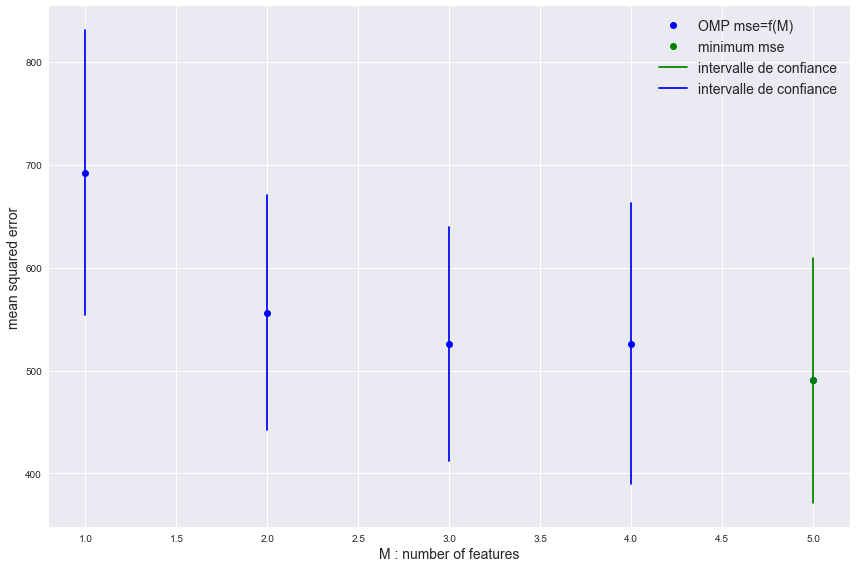

In [108]:
#Plot
plt.style.use('seaborn')
fig,ax = plt.subplots(figsize=(12,8))
x = np.array([1,2,3,4,5])

ax.plot(x,np.abs(gscv_omp.cv_results_["mean_test_score"]),'bo')

masque_index_min = np.argmin(np.abs(gscv_omp.cv_results_["mean_test_score"]))

#Plot du min en vert
ax.plot(x[masque_index_min], np.min(np.abs(gscv_omp.cv_results_["mean_test_score"])),'go')

#Plot des écart-types
lim_basse = np.abs(gscv_omp.cv_results_["mean_test_score"]) - gscv_omp.cv_results_["std_test_score"]
lim_haute = np.abs(gscv_omp.cv_results_["mean_test_score"]) + gscv_omp.cv_results_["std_test_score"]
ax.plot([x[masque_index_min],x[masque_index_min]], [lim_basse[4],lim_haute[4]],'g-')
ax.plot([x[3],x[3]], [lim_basse[3],lim_haute[3]],'b-')
ax.plot([x[2],x[2]], [lim_basse[2],lim_haute[2]],'b-')
ax.plot([x[1],x[1]], [lim_basse[1],lim_haute[1]],'b-')
ax.plot([x[0],x[0]], [lim_basse[0],lim_haute[0]],'b-')


ax.set_ylabel("mean squared error",fontsize=14)
ax.set_xlabel("M : number of features",fontsize=14)
ax.legend(["OMP mse=f(M)","minimum mse","intervalle de confiance","intervalle de confiance"],fontsize=14)
plt.tight_layout()


L'intervalle de confiance défini est +|- l'ecart type plus le mse. On se rend compte sur le graphique que l'intervalle de confiance du min mse (5 feautures) englobe également les mse pour un modèle à 1, 2, 3, 4 features. En considérant les intervalles de confiance, il existe un risque non négligeable de se tromper en affirmant que le modèle à 5 features est le meilleur du point de vue de la minimisation du mse

*********************************************END OF STATS*************************************************************